In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os

In [2]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
        
    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
    
        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [3]:
net=cv2.dnn.readNet('frozen_east_text_detection.pb')

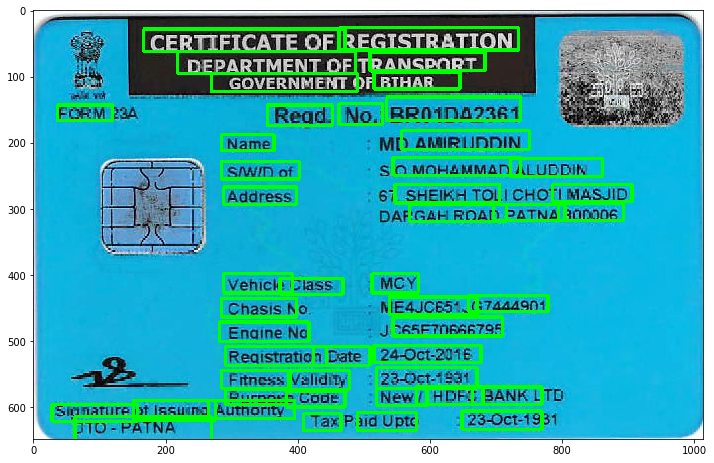

In [6]:
#list_images=os.listdir('RC')
#for i in range(len(list_images)):
for i in range(1):
    #a=''.join('RC/'+list_images[i])
    img=cv2.imread('test.jpg')
    orig=img.copy()
    (h,w)=img.shape[:2]
    (neww,newh)=(320,320)
    rw=w/float(neww)
    rh=h/float(newh)
    image=cv2.resize(img,(neww,newh))
    (h,w)=image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (w,h),(123.68, 116.78, 103.94), swapRB=True, crop=False)
    OutputLayers = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    net.setInput(blob)
    output=net.forward(OutputLayers)
    (scores,geometry)=(output[0],output[1])
    (numRows,numCols)=scores.shape[2:4]



    rects=[]
    confidences=[]

    for y in range(0,numRows):
        scoresData=scores[0,0,y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    #boxes=cv2.dnn.NMSBoxesR(np.array(rects),confidences)
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rw)
        startY = int(startY * rh)
        endX = int(endX * rw)
        endY = int(endY * rh)
        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 3)
    # show the output image
    fig=plt.figure(figsize=(12,10))
    ax=fig.add_subplot(111)
    ax.imshow(orig)
    #cv2.imshow("Text Detection", orig)
    #cv2.waitKey(0)
